In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd "/content/drive/My Drive/fer"


/content/drive/My Drive/fer


In [4]:
ls

cml/            fer_data.npz  final.py        nparrayconverter.py
ferCnnKeras.py  fer.ipynb     modelLoader.py  saved_model.h5


In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=8f300b2d847121a22a175adcff1a516ee3a613e9e1fe697b6796e232b2b07319
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [7]:
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.6 GB  | Proc size: 443.2 MB
GPU RAM Free: 11372MB | Used: 69MB | Util   1% | Total 11441MB


In [8]:
import numpy as np
from keras.layers import Conv2D,MaxPooling2D,Reshape
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense,Flatten,BatchNormalization
from keras.optimizers import Adam
from keras.layers import Dropout
import matplotlib.pyplot as plt
from keras.regularizers import l2

Using TensorFlow backend.


In [0]:
import gc

In [10]:
gc.collect()

22

In [11]:
fer = np.load('fer_data.npz')
data,label = fer['data']/255,fer['label']
data = (data - np.mean(data))/np.std(data)
size_of_data = len(label)
code = np.zeros((size_of_data,7))
code[np.arange(size_of_data),label] = 1
print(data[1].shape,code[1].shape)

(2304,) (7,)


In [12]:
print(data.shape,code.shape)

(35887, 2304) (35887, 7)


In [0]:
ratio = 25000
train_data =  data[:ratio]
train_cls = label[:ratio]
train_label = code[:ratio]
validation_data = data[ratio:]
validation_cls = label[ratio:]
validation_label = code[ratio:]

In [0]:
#image features

img_size = 48
img_size_flat = 2304
img_shape = [48,48]
img_shape_full = [48,48,1]
num_classes = 7

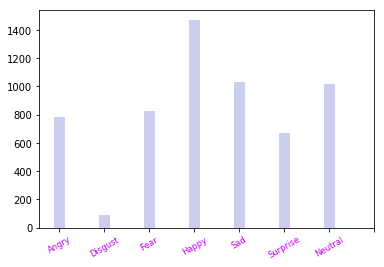

In [15]:
def dataDistribution(label):
    '''  0: -4593 images- Angry
    1: -547 images- Disgust
    2: -5121 images- Fear
    3: -8989 images- Happy
    4: -6077 images- Sad
    5: -4002 images- Surprise
    6: -6198 images- Neutral'''
    figure = plt.figure()
    ax = figure.add_subplot(1,1,1)
    ax.hist(label, [0,1,2,3,4,5,6,7],rwidth = .25,align = 'left',color = '#CDCDEF')
    ax.set_xticks([0,1,2,3,4,5,6,7])
    ax.set_xticklabels(['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral'],
                        rotation = 30,fontsize = 'small',color = '#C200F1')
dataDistribution(label[30000:])


In [22]:
def Model():
    model = Sequential()
    #model.add(InputLayer(input_shape=(img_size_flat,)))
    #print("shape outputted by the Input layer: ",model.output_shape)
    model.add(Reshape(img_shape_full))
    
    model.add(Conv2D(filters = 64,kernel_size = 5,input_shape = img_shape_full,activation = 'relu',strides = (1,1),name = 'layer_conv1'))
   
    model.add(MaxPooling2D(pool_size = (3,3),strides = (2,2)))
    
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters = 64,kernel_size = 5,activation = 'relu',strides = (1,1),name = 'layer_conv2'))
    
    model.add(MaxPooling2D(pool_size = (3,3),strides = (2,2)))
    
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters = 64,kernel_size = 4,activation = 'relu'))
    
    model.add(Dropout(rate = .3))
    
    model.add(Flatten())
    
    model.add(Dense(200,kernel_regularizer = l2(.002),activation = 'relu'))
    
    model.add(Dense(num_classes,activation = 'softmax'))
    optimizer = Adam(.001)
    model.compile(optimizer = optimizer,loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.fit(x= train_data,y=train_label,epochs = 30,batch_size = 32,validation_split = .2)
    result = model.evaluate(x = validation_data,y = validation_label)
    for name,value in zip(model.metrics_names,result):
        print('{0}: {1}'.format(name,value))
    return model

m = Model()

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 12s 593us/step - loss: 2.0206 - acc: 0.3849 - val_loss: 1.6551 - val_acc: 0.4610
Epoch 2/30
20000/20000 [==============================] - 11s 527us/step - loss: 1.5243 - acc: 0.4722 - val_loss: 1.4137 - val_acc: 0.5038
Epoch 3/30
20000/20000 [==============================] - 10s 523us/step - loss: 1.3574 - acc: 0.5144 - val_loss: 1.3282 - val_acc: 0.5362
Epoch 4/30
20000/20000 [==============================] - 10s 520us/step - loss: 1.2772 - acc: 0.5484 - val_loss: 1.3131 - val_acc: 0.5448
Epoch 5/30
20000/20000 [==============================] - 10s 521us/step - loss: 1.2122 - acc: 0.5695 - val_loss: 1.2721 - val_acc: 0.5660
Epoch 6/30
20000/20000 [==============================] - 10s 523us/step - loss: 1.1627 - acc: 0.5918 - val_loss: 1.2467 - val_acc: 0.5784
Epoch 7/30
20000/20000 [==============================] - 10s 519us/step - loss: 1.1146 - acc: 0.6149 - val_loss: 1.2

In [23]:
import os

m.summary()

try:
    os.remove('saved_model.h5')
except FileNotFoundError as err:   
    m.save('saved_model.h5')
    print("model saved")
else:
    m.save('saved_model.h5')
    print("model_saved again")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 48, 48, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 44, 44, 64)        1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 21, 21, 64)        256       
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 17, 17, 64)        102464    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 64)         

In [0]:
del m

In [19]:
from keras.models import load_model
m_r = load_model('saved_model.h5')

m_r.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 48, 48, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 44, 44, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 64)        256       
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 17, 17, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 64)         